Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

In [1]:
#conda install conda=23.7.3

In [2]:
conda update -n base -c defaults conda

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.3



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install pytorch torchvision -c pytorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.3



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install torch 

In [5]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [7]:
latent_dims = 10
num_epochs = 1
batch_size = 128
#batch_size=32
#learning_rate = 2e-4
learning_rate=0.1
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [8]:
"""from torch.utils.data import SubsetRandomSampler

# Define a subset size (e.g., 10% of the dataset)
subset_fraction = 0.1
num_samples = int(len(dataset) * subset_fraction)

# Create a random subset sampler
subset_sampler = SubsetRandomSampler(range(num_samples))

# Create a dataloader using the subset sampler
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler)
"""

'from torch.utils.data import SubsetRandomSampler\n\n# Define a subset size (e.g., 10% of the dataset)\nsubset_fraction = 0.1\nnum_samples = int(len(dataset) * subset_fraction)\n\n# Create a random subset sampler\nsubset_sampler = SubsetRandomSampler(range(num_samples))\n\n# Create a dataloader using the subset sampler\ntrain_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler)\n'

In [9]:
"""from torch.utils.data import SubsetRandomSampler

subset_fraction = 0.1  # Use 10% of the dataset
num_train_samples = int(len(train_dataset) * subset_fraction)
num_test_samples = int(len(test_dataset) * subset_fraction)

# Create random samplers for training and test subsets
train_sampler = SubsetRandomSampler(range(num_train_samples))
test_sampler = SubsetRandomSampler(range(num_test_samples))

# Create dataloaders for the subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)
"""

'from torch.utils.data import SubsetRandomSampler\n\nsubset_fraction = 0.1  # Use 10% of the dataset\nnum_train_samples = int(len(train_dataset) * subset_fraction)\nnum_test_samples = int(len(test_dataset) * subset_fraction)\n\n# Create random samplers for training and test subsets\ntrain_sampler = SubsetRandomSampler(range(num_train_samples))\ntest_sampler = SubsetRandomSampler(range(num_test_samples))\n\n# Create dataloaders for the subsets\ntrain_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)\ntest_dataloader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)\n'

In [10]:
"""img_transform = transforms.Compose([
    transforms.Resize(32),  # Change the size to 32x32 or another desired size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
"""

'img_transform = transforms.Compose([\n    transforms.Resize(32),  # Change the size to 32x32 or another desired size\n    transforms.ToTensor(),\n    transforms.Normalize((0.5,), (0.5,))\n])\n'

In [11]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#download=False done
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
from torch.utils.data import SubsetRandomSampler

subset_fraction = 0.1  # Use 10% of the dataset
num_train_samples = int(len(train_dataset) * subset_fraction)
num_test_samples = int(len(test_dataset) * subset_fraction)

# Create random samplers for training and test subsets
train_sampler = SubsetRandomSampler(range(num_train_samples))
test_sampler = SubsetRandomSampler(range(num_test_samples))

# Create dataloaders for the subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)


In [13]:
len(train_dataloader)

47

In [14]:
len(test_dataloader)

8

GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [15]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033985


In [16]:
"""https://chat.openai.com/share/bda17eba-f981-435f-9322-d50335284e79"""

'https://chat.openai.com/share/bda17eba-f981-435f-9322-d50335284e79'

Train GAN
--------


In [18]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    print(1)
    for image_batch, _ in train_dataloader:
        print(2)
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)
        print(3)
        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        print(4)
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        print(4.1)
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        print(4.2)
        disc_loss = 0.75 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        print(4.3)
        disc_optimizer.zero_grad()
        print(4.4)
        disc_loss.backward()
        print(4.5)
        disc_optimizer.step()
        print(5)
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        print(6)
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
1
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5
5
6
2
3
4
4.1
4.2
4.3
4.4
4.5

Plot Training Curves
--------------------

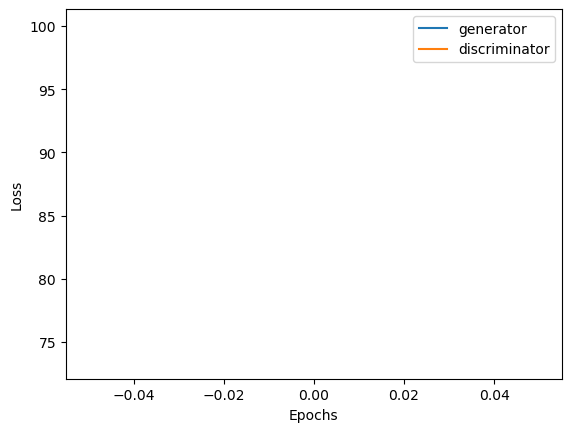

In [25]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively: Load Pre-Trained GAN
-----------------------------

In [20]:
""""""

''

In [22]:
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/dcgan.pth", "./pretrained/dcgan.pth")
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/dcgan_discriminator.pth", "./pretrained/dcgan_discriminator.pth")
generator.load_state_dict(torch.load('./pretrained/dcgan.pth'))
discriminator.load_state_dict(torch.load('./pretrained/dcgan_discriminator.pth'))
print('done')

# this is how the GAN parameters can be saved:
# torch.save(generator.state_dict(), './pretrained/my_dcgan.pth')
# torch.save(discriminator.state_dict(), './pretrained/my_dcgan_discriminator.pth')

downloading ...


TimeoutError: [Errno 60] Operation timed out

Interpolate in Latent Space
----------------------------

NameError: name 'to_img' is not defined

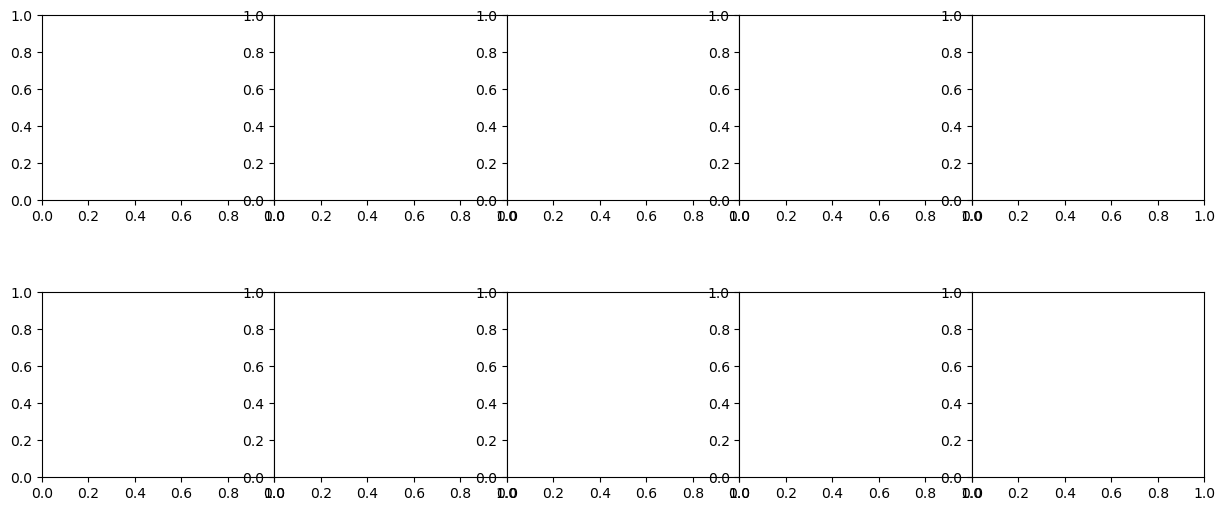

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

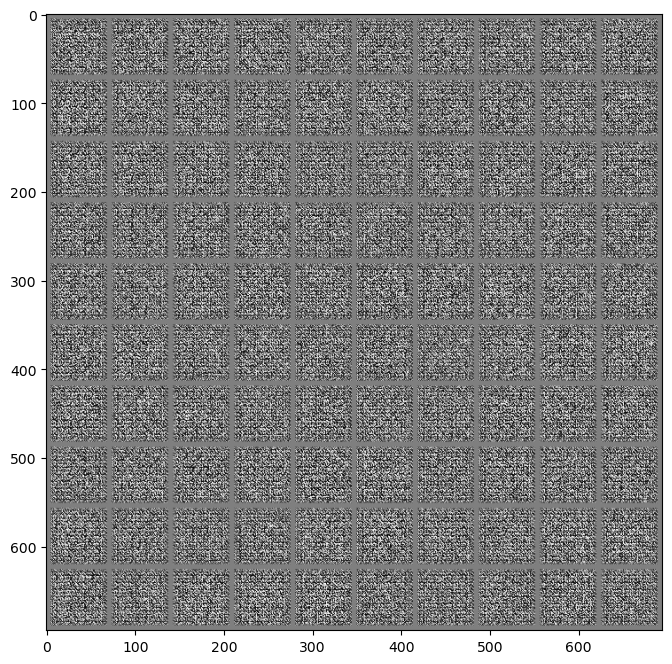

In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()